## Setup

In [84]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.animation as animation
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
from IPython import display
from mpl_toolkits.mplot3d import Axes3D
import warnings
import math as m
warnings.filterwarnings('ignore')
plt.rcParams["figure.figsize"] = (6,4)
plt.rcParams["figure.dpi"] = 100

## Defining useful functions

In [85]:
def plotMagnetization(dt, M_to_plot):
    time_vector = np.array(range(len(M_to_plot)))*dt
    plt.plot(time_vector, np.array(M_to_plot)[:,0])
    plt.plot(time_vector, np.array(M_to_plot)[:,1])
    plt.plot(time_vector, np.array(M_to_plot)[:,2])
    plt.ylabel("Magnetization")
    plt.xlabel("Time (s)")
    plt.legend(['Mx', 'My', 'Mz'])
    plt.ylim([np.array(M_to_plot).min() - 0.1, np.array(M_to_plot).max() + 0.1])
    
def plotComplexMagnetization(dt, M_to_plot):
    fig, axs = plt.subplots(2)
    axs[0].set_ylabel("Amplitude")
    axs[1].set_ylabel("Angle (degree)")
    axs[1].set_xlabel("Time (s)")
    axs[0].set_title('Complex transverse magnetization')
    Mxy = []
    for M_i in M_to_plot:
        # Mxy = Mx + i*My
        Mxy.append(complex(M_i[0], M_i[1]))
    Mxy= np.array(Mxy, dtype=np.complex_)
    time_vector = np.array(range(len(M_to_plot)))*dt
    axs[0].plot(time_vector, np.abs(Mxy))

    axs[1].plot(time_vector, np.rad2deg(np.angle(Mxy)))
    
    return Mxy

def customPlotTransverseMagnetization(dt, M):
    Mxy = []
    for M_i in M:
        # Mxy = Mx + i*My
        Mxy.append(complex(M_i[0], M_i[1]))
    Mxy= np.array(Mxy, dtype=np.complex_)
    time_vector = np.array(range(len(M)))*dt
    plt.plot(time_vector, np.abs(Mxy))
    return Mxy

def calculate_steady_state_magnetization(Mo, alpha, TR, T1):
    rad_alpha = m.radians(alpha)
    term1 = Mo * m.sin(rad_alpha)
    term2 = 1 - m.exp(-TR / T1)
    term3 = 1 - m.cos(rad_alpha) * m.exp(-TR / T1)
    Mss_xy = term1 * (term2 / term3)
    return Mss_xy

def excitation(M_to_excite, flip_angle):
    dTheta = np.deg2rad(flip_angle)
    
    A = np.array([
        [1, 0, 0],
        [0, np.cos(dTheta), np.sin(dTheta)],
        [0,-np.sin(dTheta),  np.cos(dTheta)],
    ])
    
    M_to_excite[-1] = A @ M_to_excite[-1]


def relaxation(M, dt, duration):
    A = np.array([
        [np.exp(-dt/T2), 0, 0],
        [0, np.exp(-dt/T2), 0],
        [0, 0, np.exp(-dt/T1)],
    ])

    B = np.array([
        0,
        0,
        1*(1 - np.exp(-dt/T1))
    ])

    for _ in range(int(duration/dt)):
        M.append(A @ M[-1] + B)

def calculate_steady_magnetization(M_avg):
    z = np.array(M_avg)[:, 2]
    peaks = find_peaks(z, distance=10)
    peaks = peaks[0]
    z = [z[i] for i in peaks] 
    return z[-1]

def saturation_recovery_sequence(TR, NEX, flip_angle = 90):
    M = [M0]
    for i in range(NEX):
        excitation(M, flip_angle = flip_angle)
        relaxation(M, dt, duration=TR)
    return M

def calculate_ernst_angle(TR, T1):
     return np.rad2deg(np.arccos(np.exp(-TR/T1)))

## Declaring constants

In [86]:
# Relevant information
M0 = np.array([0, 0, 1])
dt = 1/1000   # s
T1 = 800/1000.0  # s
T2 = 80/1000.0    # s
TE = 1/1000.0     # s
TR = 1   # s
flip_angle = 60
NEX = 10

## Question 1
Draw the pulse sequence diagram (including indication of the RF pulses, signal
acquisition times, TE and TR). Compute the total study duration

![Pulse diagram](pulse-sequence-diagram.png)

In [87]:
print(f'Total duration: {NEX*TR}s')

Total duration: 10s


 This generates a plot showing the pulse sequence diagram with indication of the RF pulses, signal acquisition times, TE, and TR. It also prints the total study duration.
 We have assumed a constant flip angle throughout the sequence and neglects any relaxation during the RF pulses. It uses the idealized equations for T1 and T2 relaxation, and the magnetization is updated at each time step. This can be modified as wanted by changing the code or the equations.

## Question 2 
Simulate the evolution of the longitudinal and transverse magnetization during the sequence. Indicate which component of the magnetization is measured and plot its amplitude at each acquisition time

measurements [0.8552674634412614, 0.7419668012790793, 0.7241939531038114, 0.7126835932751998, 0.7123234309679874, 0.7122718388670612, 0.7122644484632769, 0.7122633898115239, 0.7212224067884481, 0.7122632164398776]


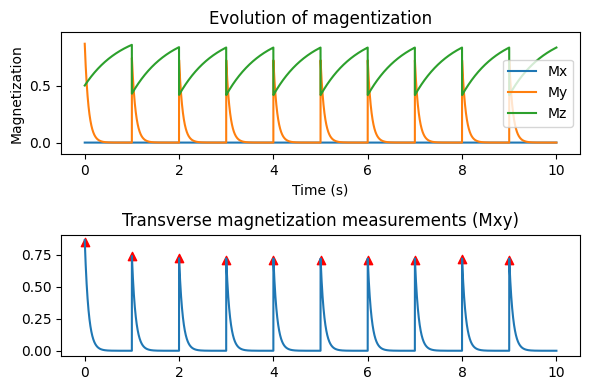

In [88]:
M = [M0]

for _ in range(NEX):
    # Excitation
    excitation(M, flip_angle = flip_angle)

    # Relaxation
    relaxation(M, dt, duration = TR)

# Plotting magnetization
plt.subplot(211)
plotMagnetization(dt, M)
plt.title("Evolution of magentization")

plt.subplot(212)
plt.title("Transverse magnetization measurements (Mxy)")
Mxy = customPlotTransverseMagnetization(dt, M)
measurement_times = np.array([N*TR + TE for N in range(NEX)])
measurements = [np.abs(Mxy)[int(t/dt)] for t in measurement_times]
plt.scatter(measurement_times, measurements, marker='^', c='r')
plt.tight_layout()

print('measurements', measurements)

## Question 3
Calculate the steady-state magnetization, Mss, and determine this from the data

![Pulse diagram](ss_eqs.png)

In [89]:
def printSteasdyStateValues():
    # Teorethical Steady State Magnetization
    Mss_z_t = (1 - np.exp(-TR/T1))/(1 - np.exp(-TR/T1)*np.cos(np.deg2rad(flip_angle)))
    Mss_xy_t = (1 - np.exp(-TR/T1))*np.sin(np.deg2rad(flip_angle))/(1 - np.exp(-TR/T1)*np.cos(np.deg2rad(flip_angle)))*np.exp(-TE/T2)

    print("Theoretical values:")
    print('Longitudinal SS:', Mss_z_t)
    print('Transversal SS:', Mss_xy_t)

    print("\nMeasured values:")
    z = np.array(np.array(M)[:,2])
    peaks, _ = find_peaks(z, distance=10)
    z = [z[i] for i in peaks]
    Mss_z_m = z[-1]
    print('Longitudinal SS:', z[-1])

    z = np.array(np.abs(Mxy))
    peaks, _ = find_peaks(z, distance=10)
    z = [z[i] for i in peaks]
    Mss_xy_m = z[-1]
    print('Transversal SS: ', z[-1])

    return Mss_z_t, Mss_z_m, Mss_xy_t, Mss_xy_m

Q3_Mss_z_t, Q3_Mss_xy_m, Q3_Mss_z_t, Q3_Mss_xy_m = printSteasdyStateValues()

Theoretical values:
Longitudinal SS: 0.8327950983841691
Transversal SS: 0.712262551361344

Measured values:
Longitudinal SS: 0.8325851864612156
Transversal SS:  0.7212223847920429


## Question 4 
Repeat 2 and 3, if TR is reduced to 100 ms and NEX is increased to 100 (yielding the same total study duration).

In [90]:
TR = 100/1000 # s
NEX = 100

measurements [0.8552674634412614, 0.6004011351942958, 0.23518607000687677, 0.08615785349161326, 0.09139156376962043, 0.13213090590153811, 0.15461979680352497, 0.15746405384706508, 0.15344044242008775, 0.1503694973208133, 0.1514734894940925, 0.14991377985156876, 0.1502985634788202, 0.15044207463515386, 0.15042866849118902, 0.15227615202638503, 0.15036214800792203, 0.1503602111986315, 0.15036474255634297, 0.1503678808408538, 0.15225997322840443, 0.1503681784824881, 0.15036777584212616, 0.15036763935414163, 0.15036766138022514, 0.15036770876405645, 0.15036773089087999, 0.1503677318435184, 0.15036772680579924, 0.1503677236203835, 0.15036772303224016, 0.15036772349386912, 0.15036772391239744, 0.15036772404030951, 0.1503677240092538, 0.1503677239587605, 0.15036772393709918, 0.15036772393720488, 0.15036772394274342, 0.15036772394595407, 0.1503677239464302, 0.15036772394589681, 0.15036772394546458, 0.1503677239453468, 0.15036772394538725, 0.15036772394544082, 0.15036772394546183, 0.15036772394

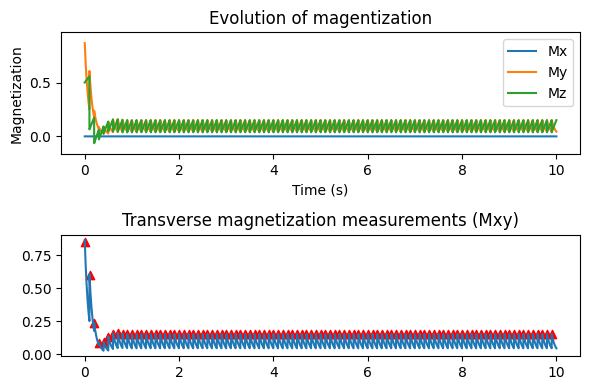

In [91]:
M = [M0]

for _ in range(NEX):
    # Excitation
    excitation(M, flip_angle = flip_angle)

    # Relaxation
    relaxation(M, dt, duration = TR)

# Plotting magnetization
plt.subplot(211)
plotMagnetization(dt, M)
plt.title("Evolution of magentization")

plt.subplot(212)
plt.title("Transverse magnetization measurements (Mxy)")
Mxy = customPlotTransverseMagnetization(dt, M)
measurement_times = np.array([N*TR + TE for N in range(NEX)])
measurements = [np.abs(Mxy)[int(t/dt)] for t in measurement_times]
plt.scatter(measurement_times, measurements, marker='^', c='r')
plt.tight_layout()

print('measurements', measurements)

In [92]:
Q4_Mss_z_t, Q4_Mss_xy_m, Q4_Mss_z_t, Q4_Mss_xy_m = printSteasdyStateValues()

Theoretical values:
Longitudinal SS: 0.21029578832876497
Transversal SS: 0.17985914545632323

Measured values:
Longitudinal SS: 0.14956557357547423
Transversal SS:  0.15225911707437523


Valores teóricos já não modelam o Steady State de forma adequada, já que a condição TR >> T2 não se verifica.

## Question 5
Compute the Ernst angle, the flip angle that maximizes the value of Mss, for each TR
value considered. Verify that the given value of 60º is close to optimal for TR = 1 s
but not TR = 100 ms.

1. Case: TR = 1s

In [93]:
TR = 1
calculate_ernst_angle(TR, T1)

73.35118145951641

2. Case: TR = 100ms


In [94]:
TR = 0.1
flip_angle = calculate_ernst_angle(TR, T1)
flip_angle

## Question 6
Repeat 4 using the Ernst angle for TR = 100 ms

measurements [0.46447582154872613, 0.5337493602278793, 0.4877768609354747, 0.4228346808279728, 0.36746137367605214, 0.32675598867527866, 0.29876323446944475, 0.28017671200542343, 0.26807978158751483, 0.2602995085351644, 0.25854332445031675, 0.25217376294543253, 0.2501720334553265, 0.24890540678892387, 0.2481048200500903, 0.2507135698008429, 0.24727991220524326, 0.2470784195438267, 0.24695126900424585, 0.24687104069648846, 0.24992504135094742, 0.24678848787290147, 0.24676834094496977, 0.24675563093059757, 0.24674761270766993, 0.24674255438002768, 0.24673936332922644, 0.2467373502578854, 0.24673608031619926, 0.24673527917722107, 0.24673477378144462, 0.24673445495440988, 0.2467342538236308, 0.24673412694109614, 0.24673404689777503, 0.24673399640278165, 0.24673396454822846, 0.2467339444529188, 0.24673393177587832, 0.24673392377862155, 0.2467339187335862, 0.2467339155509472, 0.24673391354319302, 0.24673391227660996, 0.24673391147759138, 0.2467339109735341, 0.2467339106555516, 0.246733910454

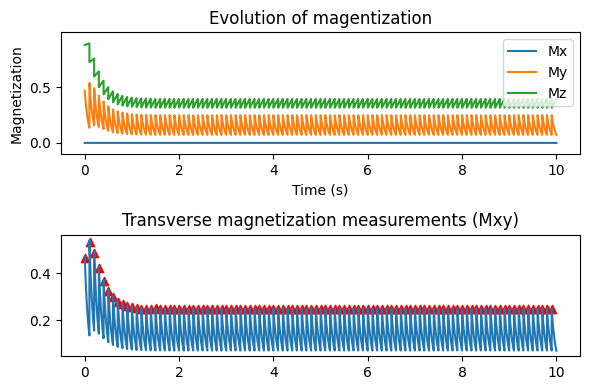

In [95]:
M = [M0]

for _ in range(NEX):
    # Excitation
    excitation(M, flip_angle = flip_angle)

    # Relaxation
    relaxation(M, dt, duration = TR)

# Plotting magnetization
plt.subplot(211)
plotMagnetization(dt, M)
plt.title("Evolution of magentization")

plt.subplot(212)
plt.title("Transverse magnetization measurements (Mxy)")
Mxy = customPlotTransverseMagnetization(dt, M)
measurement_times = np.array([N*TR + TE for N in range(NEX)])
measurements = [np.abs(Mxy)[int(t/dt)] for t in measurement_times]
plt.scatter(measurement_times, measurements, marker='^', c='r')
plt.tight_layout()

print('measurements', measurements)

In [96]:
Q6_Mss_z_t, Q6_Mss_xy_m, Q6_Mss_z_t, Q6_Mss_xy_m = printSteasdyStateValues()

Theoretical values:
Longitudinal SS: 0.5312093733737563
Transversal SS: 0.24673391011215948

Measured values:
Longitudinal SS: 0.39614426201554137
Transversal SS:  0.24983744064393024


## Question 7
Indicate how the SNR varies with NEX, and compare the overall SNR per unit time of Mss in 4 vs. 3 and 6 vs. 3.

SNR ∝ √NEX
Increasing the number of repetitions (N) and averaging the images can help improve the SNR by reducing the random noise component. However, it is important to note that there may be limitations to how much the SNR can be improved by signal averaging, as there are other noise sources and limitations imposed by the system.

Regarding the TR and flip angle, they both affect the signal intensity and contrast in an MRI image. A shorter TR results in less recovery of the longitudinal magnetization (Mz) and can lead to lower signal intensity. On the other hand, a smaller flip angle allows more time for Mz to recover, resulting in a higher transverse magnetization (Mxy) and therefore higher signal intensity in the xy plane. The choice of TR and flip angle depends on the specific imaging goals and the desired contrast in the image.

In [97]:
import pandas as pd

TR3,   TR4,  TR6 =  1, 0.1, 0.1
NEX3, NEX4, NEX6 = 10, 100, 100
Q3_SNR_factor = np.sqrt(NEX3)*Q3_Mss_xy_m
Q4_SNR_factor = np.sqrt(NEX4)*Q4_Mss_xy_m
Q6_SNR_factor = np.sqrt(NEX6)*Q6_Mss_xy_m

data = [
    [TR3, NEX3, Q3_Mss_xy_m, Q3_SNR_factor, Q3_SNR_factor/Q3_SNR_factor],
    [TR4, NEX4, Q4_Mss_xy_m, Q4_SNR_factor, Q4_SNR_factor/Q3_SNR_factor],
    [TR6, NEX6, Q6_Mss_xy_m, Q6_SNR_factor, Q6_SNR_factor/Q3_SNR_factor],
]
  
df = pd.DataFrame(data, index=['Q3', 'Q4', 'Q6'], columns=['TR (s)', 'NEX', 'M_ss_xy', 'SNR_factor', 'SNR comparison to Q3'])
df

,TR (s),NEX,M_ss_xy,SNR_factor,SNR comparison to Q3
Q3,1.0,10,0.721222,2.280705,1.000000
Q4,0.1,100,0.152259,1.522591,0.667597
Q6,0.1,100,0.249837,2.498374,1.095439
